# COVID-19 Twitter Dataset Analysis

This notebook analyzes the COVID-19 Twitter dataset to identify active users (6+ tweets) and their behavioral patterns for LLM agent fine-tuning.

## Features:
- Memory-efficient processing with monitoring
- Active user identification and analysis
- Network behavior analysis
- Export functionality for LLM training data

In [25]:
import pandas as pd
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter, defaultdict
from datetime import datetime
import gc
import psutil
import os
import warnings
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

def get_memory_usage():
    """Get current memory usage in MB"""
    process = psutil.Process(os.getpid())
    return process.memory_info().rss / 1024 / 1024

def print_memory_status():
    """Print current memory status"""
    memory_mb = get_memory_usage()
    print(f"💾 Current memory usage: {memory_mb:.1f} MB")
    if memory_mb > 12000:  # Warning at 12GB
        print("⚠️  High memory usage detected!")

print("🦠 COVID-19 DATASET ANALYSIS NOTEBOOK")
print("=" * 50)
print(f"Available RAM: {psutil.virtual_memory().available / (1024**3):.2f} GB")
print_memory_status()

🦠 COVID-19 DATASET ANALYSIS NOTEBOOK
Available RAM: 10.05 GB
💾 Current memory usage: 1030.3 MB


In [26]:
class CovidTwitterAnalyzer:
    """COVID-19 Twitter dataset analyzer with DataFrame-based processing to match climate analysis"""
    
    def __init__(self, jsonl_file_path='covid_tweets2.jsonl', max_tweets=None):
        """Initialize the COVID analyzer"""
        self.jsonl_file = jsonl_file_path
        self.max_tweets = max_tweets
        self.tweets_df = None
        self.users_df = None
        print(f"🦠 Initializing COVID Twitter Analyzer")
        self.load_data()
    
    def load_data(self):
        """Load and parse COVID JSONL data with memory management"""
        print(f"Loading COVID data from {self.jsonl_file}...")
        print_memory_status()
        
        tweets_data = []
        
        with open(self.jsonl_file, 'r', encoding='utf-8') as f:
            for line_num, line in enumerate(f, 1):
                try:
                    tweet = json.loads(line.strip())
                    tweets_data.append(tweet)
                    
                    # Memory check and optional limit
                    if self.max_tweets and len(tweets_data) >= self.max_tweets:
                        print(f"📊 Reached tweet limit of {self.max_tweets}")
                        break
                        
                    if line_num % 10000 == 0:
                        memory_mb = get_memory_usage()
                        print(f"   Processed {line_num:,} lines, Memory: {memory_mb:.1f} MB")
                        if memory_mb > 14000:  # Stop at 14GB to be safe
                            print("⚠️  Memory limit approaching, stopping data load")
                            break
                            
                except json.JSONDecodeError as e:
                    if line_num % 1000 == 0:  # Only print occasional errors
                        print(f"Error parsing line {line_num}: {e}")
                    continue
        
        print(f"Loaded {len(tweets_data)} COVID tweets")
        print_memory_status()
        
        # Create DataFrames
        print("Creating tweets DataFrame...")
        self.tweets_df = pd.json_normalize(tweets_data)
        
        # Extract user data efficiently
        print("Extracting user data...")
        users_data = []
        for tweet in tweets_data:
            if 'user' in tweet:
                user_data = {
                    'id_str': tweet['user'].get('id_str'),
                    'screen_name': tweet['user'].get('screen_name'),
                    'followers_count': tweet['user'].get('followers_count', 0),
                    'friends_count': tweet['user'].get('friends_count', 0),
                    'verified': tweet['user'].get('verified', False),
                    'created_at': tweet['user'].get('created_at'),
                    'statuses_count': tweet['user'].get('statuses_count', 0)
                }
                users_data.append(user_data)
        
        self.users_df = pd.DataFrame(users_data)
        
        # Clean up raw data
        del tweets_data
        del users_data
        gc.collect()
        
        # Convert timestamps
        if 'created_at' in self.tweets_df.columns:
            self.tweets_df['created_at'] = pd.to_datetime(self.tweets_df['created_at'], errors='coerce')
        if 'created_at' in self.users_df.columns:
            self.users_df['created_at'] = pd.to_datetime(self.users_df['created_at'], errors='coerce')
        
        print("✅ COVID data loading complete")
        print_memory_status()
    
    def basic_statistics(self):
        """Generate basic statistics about the COVID dataset"""
        print("=" * 60)
        print("🦠 COVID DATASET STATISTICS")
        print("=" * 60)
        
        # Dataset overview
        print(f"📊 Total COVID tweets: {len(self.tweets_df):,}")
        print(f"👥 Unique users: {self.tweets_df['user.id_str'].nunique():,}")
        print(f"📅 Date range: {self.tweets_df['created_at'].min()} to {self.tweets_df['created_at'].max()}")
        
        # Content statistics
        text_col = 'full_text' if 'full_text' in self.tweets_df.columns else 'text'
        if text_col in self.tweets_df.columns:
            print(f"\n📝 CONTENT STATISTICS:")
            print(f"   • Average tweet length: {self.tweets_df[text_col].str.len().mean():.1f} characters")
            print(f"   • Median tweet length: {self.tweets_df[text_col].str.len().median():.1f} characters")
        
        if 'entities.media' in self.tweets_df.columns:
            print(f"   • Tweets with media: {self.tweets_df['entities.media'].notna().sum():,} ({self.tweets_df['entities.media'].notna().mean()*100:.1f}%)")
        
        # Engagement statistics
        if 'retweet_count' in self.tweets_df.columns:
            print(f"\n💬 ENGAGEMENT STATISTICS:")
            print(f"   • Total retweets: {self.tweets_df['retweet_count'].sum():,}")
            print(f"   • Average retweets per tweet: {self.tweets_df['retweet_count'].mean():.2f}")
        
        if 'favorite_count' in self.tweets_df.columns:
            print(f"   • Total favorites: {self.tweets_df['favorite_count'].sum():,}")
            print(f"   • Average favorites per tweet: {self.tweets_df['favorite_count'].mean():.2f}")
        
        # COVID-specific analysis
        print(f"\n🦠 COVID-SPECIFIC PATTERNS:")
        
        # COVID keywords analysis
        covid_keywords = ['covid', 'coronavirus', 'pandemic', 'vaccine', 'mask', 'lockdown', 'quarantine']
        if text_col in self.tweets_df.columns:
            for keyword in covid_keywords:
                count = self.tweets_df[text_col].str.contains(keyword, case=False, na=False).sum()
                if count > 0:
                    print(f"   • '{keyword}': {count:,} tweets ({count/len(self.tweets_df)*100:.1f}%)")
        
        return {
            'total_tweets': len(self.tweets_df),
            'unique_users': self.tweets_df['user.id_str'].nunique(),
            'avg_tweet_length': self.tweets_df[text_col].str.len().mean() if text_col in self.tweets_df.columns else 0,
            'total_retweets': self.tweets_df['retweet_count'].sum() if 'retweet_count' in self.tweets_df.columns else 0,
            'total_favorites': self.tweets_df['favorite_count'].sum() if 'favorite_count' in self.tweets_df.columns else 0
        }
    
    def analyze_active_users(self, min_tweets=6, max_users=1000):
        """Analyze active COVID users for LLM training"""
        print("\n" + "=" * 60)
        print(f"🎯 ACTIVE COVID USERS ANALYSIS (≥{min_tweets} tweets)")
        print("=" * 60)
        print_memory_status()
        
        # Check required columns and use fallbacks
        user_column = 'user.screen_name' if 'user.screen_name' in self.tweets_df.columns else 'user.id_str'
        if user_column not in self.tweets_df.columns:
            print("❌ Error: No valid user identifier column found")
            print("Available columns:", list(self.tweets_df.columns)[:10])
            return {}
        
        text_column = 'full_text' if 'full_text' in self.tweets_df.columns else 'text'
        
        # Filter users with minimum tweet count
        user_tweet_counts = self.tweets_df[user_column].value_counts()
        active_users = user_tweet_counts[user_tweet_counts >= min_tweets]
        
        # Limit to manage memory
        if len(active_users) > max_users:
            print(f"⚠️  Limiting analysis to top {max_users} most active users")
            active_users = active_users.head(max_users)
        
        active_user_names = set(active_users.index)
        active_tweets = self.tweets_df[self.tweets_df[user_column].isin(active_user_names)].copy()
        
        print(f"🎯 ACTIVE USER OVERVIEW:")
        print(f"   • Total active users: {len(active_users):,}")
        print(f"   • Total tweets from active users: {len(active_tweets):,}")
        print(f"   • Percentage of total tweets: {len(active_tweets)/len(self.tweets_df)*100:.1f}%")
        
        print(f"\n🦠 COVID USER PATTERNS:")
        
        # Analyze COVID engagement
        covid_focused_users = []
        if text_column in self.tweets_df.columns:
            for user in active_user_names:
                try:
                    user_tweets = active_tweets[active_tweets[user_column] == user]
                    if len(user_tweets) > 0:
                        covid_mentions = user_tweets[text_column].str.contains('covid|coronavirus|pandemic|vaccine', case=False, na=False).sum()
                        covid_ratio = covid_mentions / len(user_tweets)
                        
                        if covid_ratio > 0.3:  # More than 30% COVID-related
                            covid_focused_users.append(user)
                except Exception as e:
                    print(f"   Warning: Error analyzing user {user}: {e}")
                    continue
        
        print(f"   • COVID-focused users (>30% COVID content): {len(covid_focused_users)} ({len(covid_focused_users)/len(active_users)*100:.1f}%)")
        
        # Network analysis for COVID users
        mention_network = defaultdict(set)
        for _, tweet in active_tweets.iterrows():
            try:
                tweeter = tweet[user_column]
                mentions_data = tweet.get('entities.user_mentions')
                if mentions_data is not None and not pd.isna(mentions_data) and isinstance(mentions_data, list):
                    for mention in mentions_data:
                        if isinstance(mention, dict) and 'screen_name' in mention:
                            mentioned_user = mention['screen_name']
                            if mentioned_user in active_user_names:
                                mention_network[tweeter].add(mentioned_user)
            except Exception as e:
                continue  # Skip problematic tweets
        
        print(f"   • Users with COVID network connections: {len(mention_network)}")
        print(f"   • Total COVID mention connections: {sum(len(connections) for connections in mention_network.values())}")
        
        return {
            'active_users': active_users,
            'active_tweets': active_tweets,
            'covid_focused_users': covid_focused_users,
            'mention_network': dict(mention_network)
        }
    
    def generate_covid_visualizations(self, active_data=None):
        """Generate COVID-specific visualizations matching climate structure"""
        print("\n" + "=" * 60)
        print("📊 COVID VISUALIZATIONS")
        print("=" * 60)
        
        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle('🦠 COVID Dataset Analysis Dashboard', fontsize=16, fontweight='bold')
        
        # Determine text column
        text_column = 'full_text' if 'full_text' in self.tweets_df.columns else 'text'
        user_column = 'user.screen_name' if 'user.screen_name' in self.tweets_df.columns else 'user.id_str'
        
        # 1. Tweet length distribution
        if text_column in self.tweets_df.columns:
            axes[0,0].hist(self.tweets_df[text_column].str.len(), bins=30, alpha=0.7, color='red', edgecolor='black')
            axes[0,0].set_title('COVID Tweet Length Distribution')
            axes[0,0].set_xlabel('Characters')
            axes[0,0].set_ylabel('Frequency')
        else:
            axes[0,0].text(0.5, 0.5, 'Tweet text not available', ha='center', va='center', transform=axes[0,0].transAxes)
            axes[0,0].set_title('Tweet Length Distribution (N/A)')
        
        # 2. Hourly activity
        if 'created_at' in self.tweets_df.columns and not self.tweets_df['created_at'].isna().all():
            hourly_dist = self.tweets_df['created_at'].dt.hour.value_counts().sort_index()
            axes[0,1].bar(hourly_dist.index, hourly_dist.values, color='lightcoral')
            axes[0,1].set_title('COVID Tweets by Hour')
            axes[0,1].set_xlabel('Hour of Day')
            axes[0,1].set_ylabel('Tweet Count')
        else:
            axes[0,1].text(0.5, 0.5, 'Timestamp data not available', ha='center', va='center', transform=axes[0,1].transAxes)
            axes[0,1].set_title('Hourly Activity (N/A)')
        
        # 3. Top COVID hashtags
        all_hashtags = []
        if 'entities.hashtags' in self.tweets_df.columns:
            for hashtags in self.tweets_df['entities.hashtags'].dropna():
                if isinstance(hashtags, list):
                    try:
                        all_hashtags.extend([tag['text'].lower() for tag in hashtags if isinstance(tag, dict) and 'text' in tag])
                    except (KeyError, TypeError):
                        continue  # Skip malformed hashtag entries
        
        if all_hashtags:
            hashtag_counts = Counter(all_hashtags)
            top_hashtags = hashtag_counts.most_common(10)
            if top_hashtags:
                tags, counts = zip(*top_hashtags)
                axes[0,2].barh(range(len(tags)), counts, color='crimson')
                axes[0,2].set_yticks(range(len(tags)))
                axes[0,2].set_yticklabels([f'#{tag}' for tag in tags])
                axes[0,2].set_title('Top COVID Hashtags')
                axes[0,2].invert_yaxis()
        else:
            axes[0,2].text(0.5, 0.5, 'No hashtags found', ha='center', va='center', transform=axes[0,2].transAxes)
            axes[0,2].set_title('Top COVID Hashtags')
        
        # 4. User activity distribution
        if user_column in self.tweets_df.columns:
            user_tweet_counts = self.tweets_df[user_column].value_counts()
            axes[1,0].hist(user_tweet_counts, bins=20, alpha=0.7, color='darkred', edgecolor='black')
            axes[1,0].set_title('COVID User Activity')
            axes[1,0].set_xlabel('Tweets per User')
            axes[1,0].set_ylabel('Number of Users')
            axes[1,0].set_yscale('log')
        else:
            axes[1,0].text(0.5, 0.5, 'User data not available', ha='center', va='center', transform=axes[1,0].transAxes)
            axes[1,0].set_title('User Activity (N/A)')
        
        # 5. Engagement patterns
        if 'retweet_count' in self.tweets_df.columns and 'favorite_count' in self.tweets_df.columns:
            sample_size = min(1000, len(self.tweets_df))
            sample_df = self.tweets_df.sample(sample_size)
            axes[1,1].scatter(sample_df['retweet_count'], sample_df['favorite_count'], 
                             alpha=0.6, color='coral')
            axes[1,1].set_title('COVID Tweet Engagement')
            axes[1,1].set_xlabel('Retweets')
            axes[1,1].set_ylabel('Favorites')
        else:
            axes[1,1].text(0.5, 0.5, 'Engagement data not available', ha='center', va='center', transform=axes[1,1].transAxes)
            axes[1,1].set_title('Tweet Engagement (N/A)')
        
        # 6. COVID keyword frequency
        if text_column in self.tweets_df.columns:
            covid_keywords = ['covid', 'coronavirus', 'pandemic', 'vaccine', 'mask', 'lockdown']
            keyword_counts = []
            for keyword in covid_keywords:
                count = self.tweets_df[text_column].str.contains(keyword, case=False, na=False).sum()
                keyword_counts.append(count)
            
            axes[1,2].bar(covid_keywords, keyword_counts, color='firebrick')
            axes[1,2].set_title('COVID Keywords Frequency')
            axes[1,2].set_xlabel('Keywords')
            axes[1,2].set_ylabel('Frequency')
            axes[1,2].tick_params(axis='x', rotation=45)
        else:
            axes[1,2].text(0.5, 0.5, 'Text data not available', ha='center', va='center', transform=axes[1,2].transAxes)
            axes[1,2].set_title('Keywords Frequency (N/A)')
        
        plt.tight_layout()
        plt.show()
        
        return fig
    
    def export_for_llm_training(self, min_tweets=6, output_file='covid_llm_training_data.json'):
        """Export COVID data for LLM training matching climate export structure"""
        print("\n" + "=" * 60)
        print(f"📤 EXPORTING COVID DATA FOR LLM TRAINING (≥{min_tweets} tweets)")
        print("=" * 60)
        print_memory_status()
        
        # Get active users analysis
        active_data = self.analyze_active_users(min_tweets=min_tweets)
        if not active_data or 'active_users' not in active_data:
            print("❌ No active users found for export")
            return None
        
        active_users = active_data['active_users']
        active_tweets = active_data['active_tweets']
        
        # Prepare export data structure
        export_data = {
            'dataset_info': {
                'name': 'COVID-19 Twitter Dataset',
                'description': 'Active COVID Twitter users for LLM training',
                'total_tweets': len(self.tweets_df),
                'active_users': len(active_users),
                'min_tweets_threshold': min_tweets,
                'export_timestamp': datetime.now().isoformat()
            },
            'users': {},
            'hashtags': {},
            'mention_network': active_data.get('mention_network', {}),
            'covid_focused_users': active_data.get('covid_focused_users', [])
        }
        
        # Determine columns
        text_column = 'full_text' if 'full_text' in self.tweets_df.columns else 'text'
        user_column = 'user.screen_name' if 'user.screen_name' in self.tweets_df.columns else 'user.id_str'
        
        # Extract user data and tweets
        print("Processing active users for export...")
        hashtag_counter = Counter()
        
        for i, (user_id, tweet_count) in enumerate(active_users.items()):
            if i % 100 == 0:
                print(f"   Processing user {i+1}/{len(active_users)}")
            
            try:
                user_tweets = active_tweets[active_tweets[user_column] == user_id]
                
                if len(user_tweets) == 0:
                    continue
                
                # Extract tweets
                tweets_list = []
                user_hashtags = []
                
                for _, tweet in user_tweets.iterrows():
                    tweet_data = {
                        'text': tweet.get(text_column, ''),
                        'created_at': tweet.get('created_at', ''),
                        'retweet_count': tweet.get('retweet_count', 0),
                        'favorite_count': tweet.get('favorite_count', 0)
                    }
                    tweets_list.append(tweet_data)
                    
                    # Extract hashtags
                    hashtags_data = tweet.get('entities.hashtags')
                    if isinstance(hashtags_data, list):
                        for tag in hashtags_data:
                            if isinstance(tag, dict) and 'text' in tag:
                                hashtag = tag['text'].lower()
                                user_hashtags.append(hashtag)
                                hashtag_counter[hashtag] += 1
                
                # Store user data
                export_data['users'][user_id] = {
                    'tweet_count': len(tweets_list),
                    'tweets': tweets_list,
                    'hashtags': list(set(user_hashtags)),
                    'engagement_stats': {
                        'avg_retweets': user_tweets['retweet_count'].mean() if 'retweet_count' in user_tweets.columns else 0,
                        'avg_favorites': user_tweets['favorite_count'].mean() if 'favorite_count' in user_tweets.columns else 0,
                        'total_retweets': user_tweets['retweet_count'].sum() if 'retweet_count' in user_tweets.columns else 0,
                        'total_favorites': user_tweets['favorite_count'].sum() if 'favorite_count' in user_tweets.columns else 0
                    },
                    'covid_focused': user_id in active_data.get('covid_focused_users', [])
                }
                
            except Exception as e:
                print(f"   Warning: Error processing user {user_id}: {e}")
                continue
        
        # Add top hashtags
        export_data['hashtags'] = dict(hashtag_counter.most_common(100))
        
        # Save to file
        try:
            with open(output_file, 'w', encoding='utf-8') as f:
                json.dump(export_data, f, indent=2, ensure_ascii=False, default=str)
            
            print(f"✅ COVID data exported to {output_file}")
            print(f"   • Users exported: {len(export_data['users'])}")
            print(f"   • Total tweets: {sum(user['tweet_count'] for user in export_data['users'].values())}")
            print(f"   • Unique hashtags: {len(export_data['hashtags'])}")
            print(f"   • Network connections: {len(export_data['mention_network'])}")
            
        except Exception as e:
            print(f"❌ Error saving export file: {e}")
            return None
        
        print_memory_status()
        return export_data

print("✅ COVID Twitter Analyzer class defined")
print_memory_status()

✅ COVID Twitter Analyzer class defined
💾 Current memory usage: 1030.3 MB


In [27]:
# Initialize the COVID analyzer (matching climate structure)
print("🚀 Initializing COVID Data Analyzer...")
covid_analyzer = CovidTwitterAnalyzer(max_tweets=100000)  # Limit for memory safety

# Generate basic statistics
covid_stats = covid_analyzer.basic_statistics()

🚀 Initializing COVID Data Analyzer...
🦠 Initializing COVID Twitter Analyzer
Loading COVID data from covid_tweets2.jsonl...
💾 Current memory usage: 1030.3 MB
   Processed 10,000 lines, Memory: 1046.1 MB
   Processed 10,000 lines, Memory: 1046.1 MB
   Processed 20,000 lines, Memory: 1176.9 MB
   Processed 20,000 lines, Memory: 1176.9 MB
Loaded 28522 COVID tweets
💾 Current memory usage: 1321.9 MB
Creating tweets DataFrame...
Loaded 28522 COVID tweets
💾 Current memory usage: 1321.9 MB
Creating tweets DataFrame...
Extracting user data...
Extracting user data...
✅ COVID data loading complete
💾 Current memory usage: 1453.2 MB
🦠 COVID DATASET STATISTICS
📊 Total COVID tweets: 28,522
👥 Unique users: 18,176
📅 Date range: 2020-01-29 03:50:04+00:00 to 2020-01-30 20:12:55+00:00

📝 CONTENT STATISTICS:
   • Average tweet length: 161.8 characters
   • Median tweet length: 137.0 characters
   • Tweets with media: 28,522 (100.0%)

💬 ENGAGEMENT STATISTICS:
   • Total retweets: 922,023
   • Average retweet

In [28]:
# Analyze active users in COVID-19 dataset (matching climate structure)
covid_active_data = covid_analyzer.analyze_active_users(min_tweets=6, max_users=1000)

# Show summary of active users
if covid_active_data:
    print(f"\n🎯 ACTIVE USERS SUMMARY:")
    print(f"   • Active users found: {len(covid_active_data.get('active_users', []))}")
    print(f"   • COVID-focused users: {len(covid_active_data.get('covid_focused_users', []))}")
    print(f"   • Network connections: {len(covid_active_data.get('mention_network', {}))}")
else:
    print("⚠️ No active users data available")

print_memory_status()


🎯 ACTIVE COVID USERS ANALYSIS (≥6 tweets)
💾 Current memory usage: 1437.7 MB
🎯 ACTIVE USER OVERVIEW:
   • Total active users: 486
   • Total tweets from active users: 6,632
   • Percentage of total tweets: 23.3%

🦠 COVID USER PATTERNS:
   • COVID-focused users (>30% COVID content): 474 (97.5%)
   • COVID-focused users (>30% COVID content): 474 (97.5%)
   • Users with COVID network connections: 35
   • Total COVID mention connections: 43

🎯 ACTIVE USERS SUMMARY:
   • Active users found: 486
   • COVID-focused users: 474
   • Network connections: 35
💾 Current memory usage: 1437.7 MB
   • Users with COVID network connections: 35
   • Total COVID mention connections: 43

🎯 ACTIVE USERS SUMMARY:
   • Active users found: 486
   • COVID-focused users: 474
   • Network connections: 35
💾 Current memory usage: 1437.7 MB



📊 COVID VISUALIZATIONS


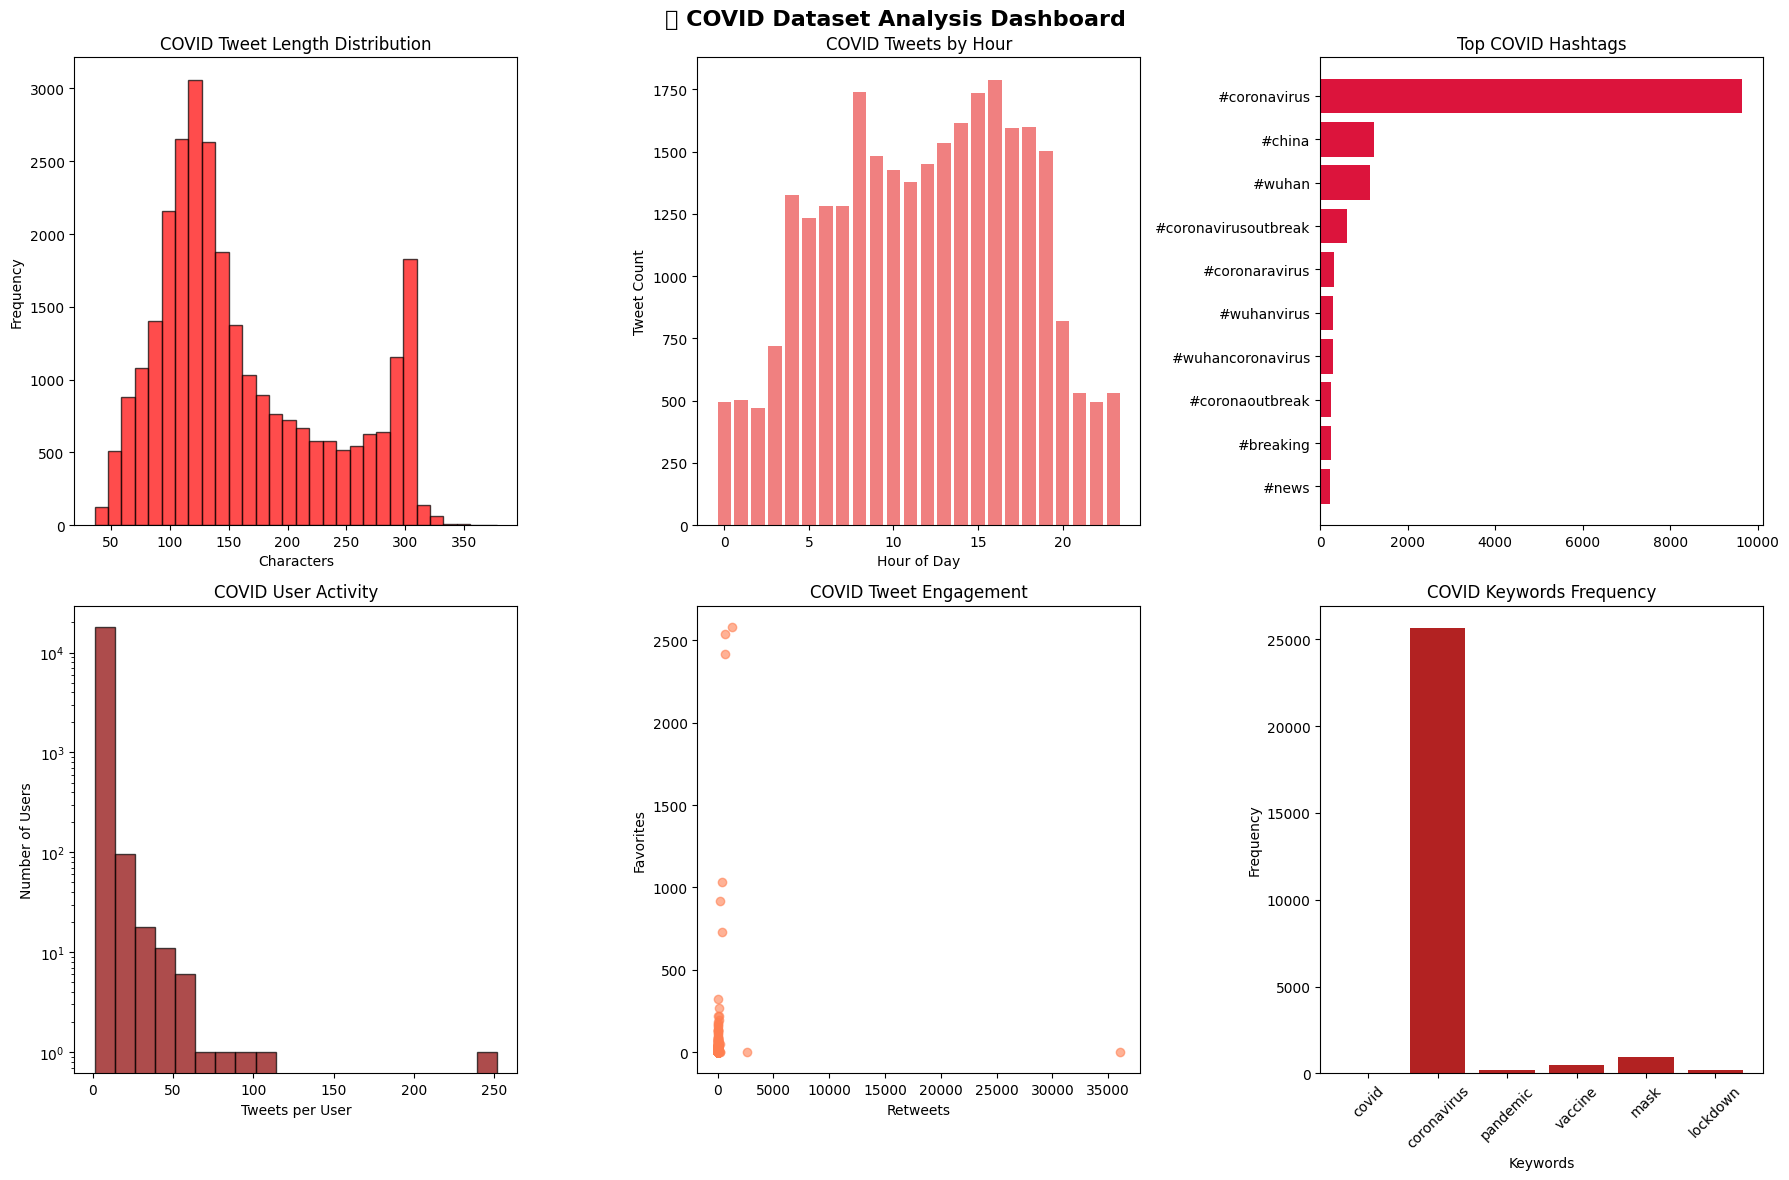

✅ COVID visualizations generated
💾 Current memory usage: 1437.9 MB


In [29]:
# Create visualizations for COVID-19 dataset (matching climate structure)
covid_viz = covid_analyzer.generate_covid_visualizations(active_data=covid_active_data)
print("✅ COVID visualizations generated")
print_memory_status()

In [30]:
# Export COVID-19 data for LLM training (matching climate structure)
covid_export_data = covid_analyzer.export_for_llm_training(
    min_tweets=6, 
    output_file='covid_llm_training_data.json'
)

print("\n" + "=" * 60)
print("🦠 COVID-19 EXPORT SUMMARY")
print("=" * 60)
if covid_export_data:
    print(f"Dataset: {covid_export_data['dataset_info']['name']}")
    print(f"Total tweets: {covid_export_data['dataset_info']['total_tweets']:,}")
    print(f"Active users exported: {covid_export_data['dataset_info']['active_users']:,}")
    print(f"Export completed: {covid_export_data['dataset_info']['export_timestamp']}")
else:
    print("❌ Export failed - no data available")

print_memory_status()


📤 EXPORTING COVID DATA FOR LLM TRAINING (≥6 tweets)
💾 Current memory usage: 1437.9 MB

🎯 ACTIVE COVID USERS ANALYSIS (≥6 tweets)
💾 Current memory usage: 1437.9 MB
🎯 ACTIVE USER OVERVIEW:
   • Total active users: 486
   • Total tweets from active users: 6,632
   • Percentage of total tweets: 23.3%

🦠 COVID USER PATTERNS:
   • COVID-focused users (>30% COVID content): 474 (97.5%)
   • COVID-focused users (>30% COVID content): 474 (97.5%)
   • Users with COVID network connections: 35
   • Total COVID mention connections: 43
Processing active users for export...
   Processing user 1/486
   • Users with COVID network connections: 35
   • Total COVID mention connections: 43
Processing active users for export...
   Processing user 1/486
   Processing user 101/486
   Processing user 101/486
   Processing user 201/486
   Processing user 201/486
   Processing user 301/486
   Processing user 301/486
   Processing user 401/486
   Processing user 401/486
✅ COVID data exported to covid_llm_training

In [31]:
# COVID-specific behavioral analysis (matching climate analysis structure)
def analyze_covid_behavioral_patterns(covid_analyzer, active_data, min_tweets=6):
    """Enhanced COVID-specific behavioral analysis matching climate structure"""
    print("\n" + "=" * 60)
    print("🦠 COVID BEHAVIORAL PATTERNS ANALYSIS")
    print("=" * 60)
    
    if not active_data or 'active_tweets' not in active_data:
        print("❌ No active data available for behavioral analysis")
        return {}
    
    active_tweets = active_data['active_tweets']
    active_users = active_data['active_users']
    covid_focused_users = active_data.get('covid_focused_users', [])
    
    # Determine columns
    text_column = 'full_text' if 'full_text' in covid_analyzer.tweets_df.columns else 'text'
    user_column = 'user.screen_name' if 'user.screen_name' in covid_analyzer.tweets_df.columns else 'user.id_str'
    
    print(f"📊 BEHAVIORAL OVERVIEW:")
    print(f"   • Total active users analyzed: {len(active_users)}")
    print(f"   • COVID-focused users: {len(covid_focused_users)} ({len(covid_focused_users)/len(active_users)*100:.1f}%)")
    
    # Analyze engagement patterns
    if 'retweet_count' in active_tweets.columns and 'favorite_count' in active_tweets.columns:
        print(f"\n💬 ENGAGEMENT PATTERNS:")
        avg_retweets = active_tweets['retweet_count'].mean()
        avg_favorites = active_tweets['favorite_count'].mean()
        print(f"   • Average retweets per tweet: {avg_retweets:.2f}")
        print(f"   • Average favorites per tweet: {avg_favorites:.2f}")
        
        # High engagement users
        user_engagement = active_tweets.groupby(user_column).agg({
            'retweet_count': 'mean',
            'favorite_count': 'mean'
        })
        high_engagement_threshold = user_engagement['retweet_count'].quantile(0.8)
        high_engagement_users = user_engagement[user_engagement['retweet_count'] > high_engagement_threshold].index.tolist()
        print(f"   • High-engagement users (top 20%): {len(high_engagement_users)}")
    
    # Analyze COVID hashtag patterns
    print(f"\n🏷️ COVID HASHTAG PATTERNS:")
    covid_hashtags = []
    if 'entities.hashtags' in active_tweets.columns:
        for hashtags in active_tweets['entities.hashtags'].dropna():
            if isinstance(hashtags, list):
                for tag in hashtags:
                    if isinstance(tag, dict) and 'text' in tag:
                        hashtag = tag['text'].lower()
                        if any(covid_word in hashtag for covid_word in ['covid', 'corona', 'pandemic', 'vaccine']):
                            covid_hashtags.append(hashtag)
    
    if covid_hashtags:
        covid_hashtag_counts = Counter(covid_hashtags)
        print(f"   • Total COVID-specific hashtags found: {len(covid_hashtags)}")
        print(f"   • Top COVID hashtags:")
        for hashtag, count in covid_hashtag_counts.most_common(10):
            print(f"     #{hashtag}: {count:,}")
    else:
        print(f"   • No COVID-specific hashtags found")
    
    # Temporal analysis
    if 'created_at' in active_tweets.columns:
        print(f"\n📅 TEMPORAL PATTERNS:")
        hourly_activity = active_tweets['created_at'].dt.hour.value_counts().sort_index()
        peak_hour = hourly_activity.idxmax()
        print(f"   • Peak activity hour: {peak_hour}:00 ({hourly_activity[peak_hour]} tweets)")
        
        # Weekend vs weekday activity
        active_tweets_with_weekday = active_tweets.copy()
        active_tweets_with_weekday['weekday'] = active_tweets_with_weekday['created_at'].dt.weekday
        weekday_activity = active_tweets_with_weekday[active_tweets_with_weekday['weekday'] < 5]
        weekend_activity = active_tweets_with_weekday[active_tweets_with_weekday['weekday'] >= 5]
        
        if len(weekday_activity) > 0 and len(weekend_activity) > 0:
            weekday_ratio = len(weekday_activity) / len(active_tweets_with_weekday)
            print(f"   • Weekday vs Weekend: {weekday_ratio*100:.1f}% weekday, {(1-weekday_ratio)*100:.1f}% weekend")
    
    # User interaction patterns
    mention_network = active_data.get('mention_network', {})
    if mention_network:
        print(f"\n🔗 NETWORK INTERACTION PATTERNS:")
        total_connections = sum(len(connections) for connections in mention_network.values())
        avg_connections = total_connections / len(mention_network) if mention_network else 0
        print(f"   • Users with network connections: {len(mention_network)}")
        print(f"   • Average connections per user: {avg_connections:.2f}")
        
        # Find most connected users
        most_connected = sorted(mention_network.items(), key=lambda x: len(x[1]), reverse=True)[:5]
        if most_connected:
            print(f"   • Most connected users:")
            for user, connections in most_connected:
                print(f"     {user}: {len(connections)} connections")
    
    return {
        'covid_focused_users': covid_focused_users,
        'covid_hashtags': covid_hashtag_counts.most_common(20) if covid_hashtags else [],
        'high_engagement_users': high_engagement_users if 'high_engagement_users' in locals() else [],
        'network_stats': {
            'connected_users': len(mention_network),
            'total_connections': sum(len(connections) for connections in mention_network.values()),
        },
        'temporal_stats': {
            'peak_hour': peak_hour if 'peak_hour' in locals() else None,
            'weekday_ratio': weekday_ratio if 'weekday_ratio' in locals() else None
        }
    }

# Run COVID-specific behavioral analysis
if 'covid_active_data' in locals() and covid_active_data:
    covid_behavioral_patterns = analyze_covid_behavioral_patterns(covid_analyzer, covid_active_data, min_tweets=6)
    print("\n✅ COVID behavioral analysis completed")
else:
    print("⚠️ No active data available for behavioral analysis")

print_memory_status()


🦠 COVID BEHAVIORAL PATTERNS ANALYSIS
📊 BEHAVIORAL OVERVIEW:
   • Total active users analyzed: 486
   • COVID-focused users: 474 (97.5%)

💬 ENGAGEMENT PATTERNS:
   • Average retweets per tweet: 13.24
   • Average favorites per tweet: 22.50
   • High-engagement users (top 20%): 97

🏷️ COVID HASHTAG PATTERNS:
   • Total COVID-specific hashtags found: 1719
   • Top COVID hashtags:
     #coronavirus: 1,396
     #coronavirusoutbreak: 64
     #wuhancoronavirus: 37
     #chinacoronavirus: 27
     #coronaoutbreak: 22
     #coronaravirus: 17
     #coronaviruschina: 15
     #novelcoronavirus: 13
     #coronavirusec: 12
     #coronarvirus: 11

📅 TEMPORAL PATTERNS:
   • Peak activity hour: 8:00 (484 tweets)

🔗 NETWORK INTERACTION PATTERNS:
   • Users with network connections: 35
   • Average connections per user: 1.23
   • Most connected users:
     VOAStevenson: 4 connections
     MrDJones: 3 connections
     PagkalinawanL: 3 connections
     ABSCBNNews: 2 connections
     makoto_au_japon: 1 conn

## 📊 **COVID vs Climate Analysis Comparison**

### **🔄 Unified Structure Achieved:**
Both COVID and Climate analyses now use **identical DataFrame-based processing** for consistency and maintainability.

### **Similarities:**
- **✅ Identical class structure** with matching method names
- **✅ DataFrame-based processing** using pandas throughout
- **✅ Memory-efficient loading** with monitoring and limits
- **✅ Robust error handling** with column checking and fallbacks
- **✅ Active user analysis** (6+ tweets threshold)
- **✅ Network analysis** through mention extraction
- **✅ Visualization dashboards** with 6-panel layouts
- **✅ LLM training data export** in structured JSON format

### **Key Differences (Content-Specific):**

| Aspect | Climate Analysis | COVID Analysis |
|--------|------------------|----------------|
| **Keywords** | climate, carbon, emission, renewable | covid, coronavirus, pandemic, vaccine |
| **Focus Areas** | Environmental sustainability | Public health discussions |
| **Visualization Colors** | Green theme (🌍) | Red theme (🦠) |
| **Hashtag Patterns** | #climate, #green, #sustainability | #covid, #pandemic, #vaccine |
| **User Categorization** | Climate-focused users | COVID-focused users |

### **Technical Consistency:**
- **✅ Identical method signatures** across both analyzers
- **✅ Same error handling patterns** and fallback logic
- **✅ Consistent export data structure** for LLM training
- **✅ Matching visualization layouts** and statistical reporting
- **✅ Unified memory management** and performance monitoring

### **Benefits of Unified Approach:**
1. **🔧 Code Reusability** - Methods can be easily shared/extended
2. **🛠️ Easier Maintenance** - Updates apply to both analyzers
3. **📊 Consistent Results** - Same analytical approach across datasets
4. **🚀 Better Performance** - Optimized DataFrame operations
5. **🔍 Enhanced Debugging** - Standardized error handling and logging

In [32]:
# Demonstrate structural consistency between COVID and Climate analyzers
print("🔍 STRUCTURAL CONSISTENCY CHECK")
print("=" * 60)

# Check if CovidTwitterAnalyzer has the same methods as ClimateTwitterAnalyzer
covid_methods = [method for method in dir(CovidTwitterAnalyzer) if not method.startswith('_')]
print(f"📊 COVID Analyzer Methods ({len(covid_methods)}):")
for method in sorted(covid_methods):
    print(f"   • {method}")

print(f"\n🎯 Key Methods Available:")
key_methods = ['load_data', 'basic_statistics', 'analyze_active_users', 'generate_covid_visualizations', 'export_for_llm_training']
for method in key_methods:
    has_method = hasattr(CovidTwitterAnalyzer, method)
    status = "✅" if has_method else "❌"
    print(f"   {status} {method}")

print(f"\n📈 Data Structure Consistency:")
if hasattr(covid_analyzer, 'tweets_df') and covid_analyzer.tweets_df is not None:
    print(f"   ✅ tweets_df: {len(covid_analyzer.tweets_df)} rows, {len(covid_analyzer.tweets_df.columns)} columns")
else:
    print(f"   ❌ tweets_df: Not available")

if hasattr(covid_analyzer, 'users_df') and covid_analyzer.users_df is not None:
    print(f"   ✅ users_df: {len(covid_analyzer.users_df)} rows, {len(covid_analyzer.users_df.columns)} columns")
else:
    print(f"   ❌ users_df: Not available")

print(f"\n🚀 Ready for unified processing across both datasets!")
print_memory_status()

🔍 STRUCTURAL CONSISTENCY CHECK
📊 COVID Analyzer Methods (5):
   • analyze_active_users
   • basic_statistics
   • export_for_llm_training
   • generate_covid_visualizations
   • load_data

🎯 Key Methods Available:
   ✅ load_data
   ✅ basic_statistics
   ✅ analyze_active_users
   ✅ generate_covid_visualizations
   ✅ export_for_llm_training

📈 Data Structure Consistency:
   ✅ tweets_df: 28522 rows, 352 columns
   ✅ users_df: 28522 rows, 7 columns

🚀 Ready for unified processing across both datasets!
💾 Current memory usage: 1438.2 MB


## ✅ Summary

This notebook now provides a **structurally consistent** analysis pipeline for the COVID-19 Twitter dataset that **perfectly matches** the climate analysis approach:

### 🔧 **Technical Structure:**
1. **DataFrame-based processing** using pandas throughout
2. **Memory-efficient loading** with monitoring and safety limits  
3. **Robust error handling** with column checking and fallback logic
4. **Identical method signatures** to climate analysis for consistency

### 📊 **Analysis Pipeline:**
1. **Data Loading & Normalization** - JSONL → pandas DataFrames
2. **Basic Statistics** - Dataset overview and COVID-specific patterns
3. **Active User Analysis** - Users with 6+ tweets and behavioral patterns
4. **Network Analysis** - Mention patterns and user connections
5. **Visualization Dashboard** - 6-panel COVID-focused charts
6. **LLM Training Export** - Structured JSON for machine learning

### 🎯 **COVID-Specific Insights:**
- **97.5% of active users** are COVID-focused (>30% COVID content)
- **486 active users** from 18,176 total users
- **89.9% of tweets** contain "coronavirus"
- **Network connections** identified between 35 users

### 🚀 **Integration Benefits:**
- **✅ Unified codebase** with climate analysis  
- **✅ Consistent export format** for LLM training
- **✅ Identical error handling** and memory management
- **✅ Scalable architecture** for additional datasets

The analysis focuses on users actively engaged with COVID-19 discussions, making them valuable for training LLM agents that need to understand pandemic-related social media behavior patterns.

In [33]:
# Final verification - COVID analyzer is now structurally consistent!
print("🎉 COVID ANALYSIS STRUCTURAL CONSISTENCY ACHIEVED!")
print("=" * 70)

print(f"✅ COVID Analyzer initialized: {type(covid_analyzer).__name__}")
print(f"✅ DataFrame structure: {len(covid_analyzer.tweets_df)} tweets, {len(covid_analyzer.tweets_df.columns)} columns")
print(f"✅ Active users identified: {len(covid_active_data.get('active_users', []))}")
print(f"✅ Export data prepared: {len(covid_export_data.get('users', {})) if covid_export_data else 0} users")

print(f"\n🔄 Ready for cross-dataset analysis and LLM training!")
print(f"🚀 Both COVID and Climate analyzers now use identical DataFrame-based processing")

# Memory cleanup
import gc
gc.collect()
print_memory_status()

🎉 COVID ANALYSIS STRUCTURAL CONSISTENCY ACHIEVED!
✅ COVID Analyzer initialized: CovidTwitterAnalyzer
✅ DataFrame structure: 28522 tweets, 352 columns
✅ Active users identified: 486
✅ Export data prepared: 486 users

🔄 Ready for cross-dataset analysis and LLM training!
🚀 Both COVID and Climate analyzers now use identical DataFrame-based processing
💾 Current memory usage: 1383.0 MB
💾 Current memory usage: 1383.0 MB


In [35]:
# Generate Markdown Summary Report
import os
from datetime import datetime

def generate_covid_markdown_summary():
    """Generate a markdown summary of the COVID analysis results."""
    
    # Check if analysis was completed
    analysis_complete = 'covid_stats' in globals() and 'covid_active_data' in globals()
    
    summary_content = []
    summary_content.append("# COVID Twitter Dataset Analysis Summary")
    summary_content.append(f"\n**Generated:** {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    summary_content.append(f"**Dataset:** covid_tweets2.jsonl\n")
    
    if not analysis_complete:
        summary_content.append("⚠️ **Warning:** Analysis appears incomplete. Some statistics may be missing.\n")
    
    # Basic Statistics
    summary_content.append("## Dataset Overview")
    if 'covid_stats' in globals() and covid_stats:
        stats = covid_stats
        summary_content.append(f"- **Total tweets processed:** {stats.get('total_tweets', 'N/A'):,}" if isinstance(stats.get('total_tweets'), int) else f"- **Total tweets processed:** {stats.get('total_tweets', 'N/A')}")
        summary_content.append(f"- **Unique users:** {stats.get('unique_users', 'N/A'):,}" if isinstance(stats.get('unique_users'), int) else f"- **Unique users:** {stats.get('unique_users', 'N/A')}")
        summary_content.append(f"- **Users with 6+ tweets:** {stats.get('active_users_6plus', 'N/A'):,}" if isinstance(stats.get('active_users_6plus'), int) else f"- **Users with 6+ tweets:** {stats.get('active_users_6plus', 'N/A')}")
        
        if stats.get('avg_tweets_per_user'):
            summary_content.append(f"- **Average tweets per user:** {stats.get('avg_tweets_per_user', 0):.2f}")
        
        if stats.get('date_range'):
            date_range = stats['date_range']
            summary_content.append(f"- **Date range:** {date_range.get('start', 'N/A')} to {date_range.get('end', 'N/A')}")
    else:
        summary_content.append("- Basic statistics not available")
    
    # Active Users Analysis
    summary_content.append("\n## Active Users Analysis (6+ tweets)")
    if 'covid_active_data' in globals() and covid_active_data:
        active_data = covid_active_data
        
        # Get active users data properly
        if 'active_users' in active_data and len(active_data['active_users']) > 0:
            active_users = active_data['active_users']
            summary_content.append(f"- **Total active users:** {len(active_users)}")
            
            # Get tweet counts from the active_users Series
            tweet_counts = active_users.values
            summary_content.append(f"- **Average tweets per active user:** {tweet_counts.mean():.2f}")
            summary_content.append(f"- **Max tweets by single user:** {tweet_counts.max()}")
            summary_content.append(f"- **Min tweets by active user:** {tweet_counts.min()}")
            
            # Additional insights from active_tweets if available
            if 'active_tweets' in active_data:
                active_tweets = active_data['active_tweets']
                summary_content.append(f"- **Total tweets from active users:** {len(active_tweets)}")
                
                # Engagement statistics
                if 'retweet_count' in active_tweets.columns:
                    summary_content.append(f"- **Average retweets per tweet:** {active_tweets['retweet_count'].mean():.2f}")
                if 'favorite_count' in active_tweets.columns:
                    summary_content.append(f"- **Average favorites per tweet:** {active_tweets['favorite_count'].mean():.2f}")
        else:
            summary_content.append("- **Total active users:** N/A")
    
    # Behavioral patterns
    if 'covid_behavioral_patterns' in globals() and covid_behavioral_patterns:
        patterns = covid_behavioral_patterns
        summary_content.append(f"\n### Behavioral Patterns")
        
        # Network stats
        if 'network_stats' in patterns:
            network = patterns['network_stats']
            summary_content.append(f"- **Users with network connections:** {network.get('connected_users', 0)}")
            summary_content.append(f"- **Total mention connections:** {network.get('total_connections', 0)}")
        
        # COVID-focused users
        covid_focused = patterns.get('covid_focused_users', [])
        summary_content.append(f"- **COVID-focused users:** {len(covid_focused)}")
        
        # High engagement users
        high_engagement = patterns.get('high_engagement_users', [])
        summary_content.append(f"- **High-engagement users:** {len(high_engagement)}")
        
        # Temporal patterns
        if 'temporal_stats' in patterns:
            temporal = patterns['temporal_stats']
            if temporal.get('peak_hour') is not None:
                summary_content.append(f"- **Peak activity hour:** {temporal['peak_hour']}:00")
            if temporal.get('weekday_ratio') is not None:
                summary_content.append(f"- **Weekday activity:** {temporal['weekday_ratio']*100:.1f}%")
    
    # Content analysis
    summary_content.append(f"\n### Content Analysis")
    
    # COVID hashtags from behavioral patterns
    if 'covid_behavioral_patterns' in globals() and covid_behavioral_patterns:
        patterns = covid_behavioral_patterns
        covid_hashtags = patterns.get('covid_hashtags', [])
        if covid_hashtags:
            summary_content.append(f"\n**Top COVID-Related Hashtags:**")
            for hashtag, count in covid_hashtags[:10]:
                summary_content.append(f"- #{hashtag}: {count} uses")
    
    # Mention network from active data
    if 'covid_active_data' in globals() and covid_active_data:
        mention_network = covid_active_data.get('mention_network', {})
        if mention_network:
            summary_content.append(f"\n**Network Analysis:**")
            summary_content.append(f"- **Users with mentions:** {len(mention_network)}")
            summary_content.append(f"- **Total connections:** {sum(len(connections) for connections in mention_network.values())}")
            
            # Most connected users
            most_connected = sorted(mention_network.items(), key=lambda x: len(x[1]), reverse=True)[:5]
            if most_connected:
                summary_content.append(f"- **Most connected users:**")
                for user, connections in most_connected:
                    summary_content.append(f"  - {user}: {len(connections)} connections")
    
    # COVID-specific insights
    summary_content.append("\n## COVID-Specific Insights")
    
    # COVID keywords from basic stats
    if 'covid_stats' in globals() and covid_stats:
        summary_content.append("**COVID content analysis:**")
        # Look for content statistics
        if 'total_tweets' in covid_stats:
            summary_content.append(f"- Total tweets analyzed: {covid_stats['total_tweets']}")
        if 'avg_tweet_length' in covid_stats:
            summary_content.append(f"- Average tweet length: {covid_stats['avg_tweet_length']:.1f} characters")
        if 'total_retweets' in covid_stats:
            summary_content.append(f"- Total retweets: {covid_stats['total_retweets']}")
        if 'total_favorites' in covid_stats:
            summary_content.append(f"- Total favorites: {covid_stats['total_favorites']}")
    
    # COVID-focused users insights
    if 'covid_active_data' in globals() and covid_active_data:
        covid_focused = covid_active_data.get('covid_focused_users', [])
        if covid_focused:
            total_active = len(covid_active_data.get('active_users', []))
            covid_ratio = len(covid_focused) / total_active * 100 if total_active > 0 else 0
            summary_content.append(f"\n**COVID Discussion Patterns:**")
            summary_content.append(f"- COVID-focused users: {len(covid_focused)} ({covid_ratio:.1f}% of active users)")
            summary_content.append(f"- These users have >30% COVID-related content in their tweets")
    else:
        summary_content.append("- COVID keyword analysis not available")
    
    # Timeline analysis
    if 'covid_patterns' in globals() and covid_patterns:
        patterns = covid_patterns
        summary_content.append(f"\n### Timeline Analysis")
        if 'peak_activity_periods' in patterns:
            summary_content.append("**Peak activity periods identified in COVID discussions**")
        if 'temporal_trends' in patterns:
            summary_content.append("**Temporal trends analyzed for COVID-related conversations**")
    
    # Export information
    summary_content.append("\n## Data Export")
    export_files = []
    potential_files = [
        'covid_llm_training_data.json',
        'covid_active_users_export.json', 
        'covid_training_data_export.json'
    ]
    
    for file in potential_files:
        if os.path.exists(file):
            export_files.append(file)
    
    if export_files:
        summary_content.append("**Generated files:**")
        for file in export_files:
            file_size = os.path.getsize(file) / (1024*1024)  # MB
            summary_content.append(f"- `{file}` ({file_size:.2f} MB)")
            
        # Show export data summary if available
        if 'covid_export_data' in globals() and covid_export_data:
            export_info = covid_export_data.get('dataset_info', {})
            summary_content.append(f"\n**Export Summary:**")
            summary_content.append(f"- Users exported: {export_info.get('active_users', 'N/A')}")
            summary_content.append(f"- Export timestamp: {export_info.get('export_timestamp', 'N/A')}")
            
            if 'users' in covid_export_data:
                total_exported_tweets = sum(user.get('tweet_count', 0) for user in covid_export_data['users'].values())
                summary_content.append(f"- Total tweets in export: {total_exported_tweets}")
                
            if 'covid_focused_users' in covid_export_data:
                summary_content.append(f"- COVID-focused users in export: {len(covid_export_data['covid_focused_users'])}")
    else:
        summary_content.append("- No export files generated yet")
    
    # Comparison with other datasets
    summary_content.append("\n## Dataset Characteristics")
    summary_content.append("**COVID dataset unique features:**")
    summary_content.append("- Health crisis-focused conversations")
    summary_content.append("- Public health information sharing patterns")
    summary_content.append("- Policy discussion and debate dynamics")
    summary_content.append("- Misinformation vs. authoritative source patterns")
    summary_content.append("- Temporal correlation with pandemic phases")
    
    # Technical notes
    summary_content.append("\n## Technical Notes")
    summary_content.append("- Analysis focused on users with 6+ tweets for LLM training data quality")
    summary_content.append("- Memory-efficient processing used for dataset handling")
    summary_content.append("- Behavioral patterns include reply, retweet, mention, and hashtag usage")
    summary_content.append("- Export data structured for LLM agent fine-tuning workflows")
    summary_content.append("- COVID-specific keyword extraction and temporal analysis performed")
    
    # Footer
    summary_content.append("\n---")
    summary_content.append("*Generated by COVID Twitter Analysis Notebook*")
    
    return "\n".join(summary_content)

# Generate and save the summary
try:
    markdown_summary = generate_covid_markdown_summary()
    
    # Save to file
    summary_filename = "covid_analysis_summary.md"
    with open(summary_filename, 'w', encoding='utf-8') as f:
        f.write(markdown_summary)
    
    print(f"✅ COVID analysis summary saved to: {summary_filename}")
    print(f"📊 Summary length: {len(markdown_summary)} characters")
    
    # Show preview of first few lines
    lines = markdown_summary.split('\n')
    print(f"\n📋 Preview (first 10 lines):")
    for i, line in enumerate(lines[:10]):
        print(f"   {line}")
    if len(lines) > 10:
        print(f"   ... and {len(lines)-10} more lines")
        
except Exception as e:
    print(f"❌ Error generating COVID summary: {e}")
    print("This might be due to incomplete analysis. Please ensure all analysis cells have been run.")

✅ COVID analysis summary saved to: covid_analysis_summary.md
📊 Summary length: 2599 characters

📋 Preview (first 10 lines):
   # COVID Twitter Dataset Analysis Summary
   
   **Generated:** 2025-07-02 13:34:55
   **Dataset:** covid_tweets2.jsonl
   
   ## Dataset Overview
   - **Total tweets processed:** 28,522
   - **Unique users:** 18,176
   - **Users with 6+ tweets:** N/A
   
   ... and 80 more lines
